# Recommendation List Data Prep

This notebook does the data preparation for the recommendation list analysis.

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

In [2]:
import ujson

In [3]:
from bookgender.config import data_dir

## Load Data

Load book gender data and clean it up:

In [4]:
book_gender = pd.read_csv('data/author-gender.csv.gz')
book_gender = book_gender.set_index('item')['gender']
book_gender.loc[book_gender.str.startswith('no-')] = 'unknown'
book_gender.loc[book_gender == 'unlinked'] = 'unknown'
book_gender = book_gender.astype('category')
book_gender.describe()

count     12234574
unique           4
top        unknown
freq       7271039
Name: gender, dtype: object

In [5]:
book_gender.head()

item
0       male
1    unknown
2       male
3    unknown
4       male
Name: gender, dtype: category
Categories (4, object): [ambiguous, female, male, unknown]

And load hashes:

In [6]:
book_hash = pd.read_parquet('data/book-hash.parquet').rename(columns={'cluster': 'item'})
book_hash['dcode'] = book_hash['md5'].apply(lambda x: int(x[-1], 16) % 2)
book_hash = book_hash.set_index('item')
book_hash.head()

,nisbns,md5,dcode
item,,,
0,17,3781b82fabd530590c70cac955b52bb0,0
1,2,4c6606ab43bfbe946a436c0ce7633a7a,0
2,38,e16249d40bf94b35d8a784d73d0511c5,1
3,2,289071ab1041c090ac252616a76fe079,1
4,4,7308735b39347b616ee6be0ab093541e,0


Load the user profile data:

In [7]:
profiles = pd.read_pickle('data/profile-data.pkl')
profiles.head()

count  linked  ambiguous  male  female  dcknown  dcyes    PropDC  \
Set user                                                                     
AZ  529       8       8          2     1       4        8      3  0.375000   
    1723     25      24          3    15       6       25     14  0.560000   
    1810     14       6          0     6       0        8      1  0.125000   
    2781      8       8          1     5       1        8      5  0.625000   
    2863      6       6          0     6       0        6      4  0.666667   

          Known  PropFemale  PropKnown  
Set user                                
AZ  529       5    0.800000   0.625000  
    1723     21    0.285714   0.840000  
    1810      6    0.000000   0.428571  
    2781      6    0.166667   0.750000  
    2863      6    0.000000   1.000000

In [8]:
datasets = list(profiles.index.levels[0])
datasets

['AZ', 'BX-E', 'BX-I', 'GR-E', 'GR-I']

And load the recommendations:

In [9]:
recs = pd.read_parquet('data/study-recs.parquet')
recs.rename(columns={'dataset': 'Set', 'algorithm': 'Algorithm'}, inplace=True)
recs.head()

,Set,Algorithm,item,score,user,rank
0,BX-E,user-user,49809,11.815094,206877,1
1,BX-E,user-user,481460,11.815094,206877,2
2,BX-E,user-user,559704,11.815094,206877,3
3,BX-E,user-user,572967,11.815094,206877,4
4,BX-E,user-user,2340806,11.815094,206877,5


The original paper truncated recommendation lists to 50. Let's do that too:

In [10]:
recs = recs[recs['rank'] <= 50]

In [11]:
recs.Set.unique()

array(['BX-E', 'BX-I', 'AZ', 'GR-E', 'GR-I'], dtype=object)

In [12]:
recs.Algorithm.unique()

array(['user-user', 'item-item', 'als', 'wrls', 'bpr', 'user-user-imp',
       'item-item-imp', 'wrls-imp', 'bpr-imp'], dtype=object)

We will need to extract implicit/explicit from those.  In the new paper, we are going to separate out implicit and explicit data for presentation; these functions will help with that.

In [13]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Algorithm'].str.endswith('-imp') | data['Set'].str.endswith('-I')
    data = data[implicit].assign(Set=data['Set'].str.replace('-I', ''),
                                 Algorithm=data['Algorithm'].str.replace('-imp', ''))
    data['Algorithm'] = data['Algorithm'].str.replace('wrls', 'als')
    return data

In [14]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Algorithm'].str.endswith('-imp') | data['Set'].str.endswith('-I')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    return data

And give ourselves a handy way to relable algorithms:

In [15]:
algo_labels = {
    'als': 'ALS',
    'bpr': 'BPR',
    'item-item': 'II',
    'user-user': 'UU'
}

## Analyze Rec List Composition

In the mean time, let's proceed by computing recommendation list gender data.

In [16]:
recs.drop(columns=['gender'], errors='ignore', inplace=True)
recs = recs.join(book_gender, on='item', how='left')
recs['gender'] = recs['gender'].fillna('unknown')
recs['gender'].describe()

count     4883258
unique          4
top          male
freq      1935586
Name: gender, dtype: object

And mix in the dummy code data:

In [17]:
recs.drop(columns=['dcode'], errors='ignore', inplace=True)
recs = recs.join(book_hash['dcode'], on='item', how='left')
recs.head()

,Set,Algorithm,item,score,user,rank,gender,dcode
0,BX-E,user-user,49809,11.815094,206877,1,female,1.0
1,BX-E,user-user,481460,11.815094,206877,2,male,0.0
2,BX-E,user-user,559704,11.815094,206877,3,male,1.0
3,BX-E,user-user,572967,11.815094,206877,4,male,1.0
4,BX-E,user-user,2340806,11.815094,206877,5,male,0.0


Count up the statistics for each list by gender:

In [18]:
rec_stats = recs.groupby(['Set', 'Algorithm', 'user'])['gender'].value_counts().unstack(fill_value=0)
rec_stats.columns = rec_stats.columns.astype('object')
rec_stats['Total'] = rec_stats.sum(axis=1)
rec_stats['Known'] = rec_stats['male'].fillna(0) + rec_stats['female'].fillna(0)
rec_stats['PropKnown'] = rec_stats['Known'] / rec_stats['Total']
rec_stats['PropFemale'] = rec_stats['female'] / rec_stats['Known']
rec_stats

gender                 ambiguous  female  male  unknown  Total  Known  \
Set  Algorithm user                                                     
AZ   als       529             2       8    19       21     50     27   
               1723            0      12     9       29     50     21   
               1810            2       6     9       33     50     15   
               2781            1       8    17       24     50     25   
               2863            2       4    25       19     50     29   
...                          ...     ...   ...      ...    ...    ...   
GR-I wrls      874933          4      32    14        0     50     46   
               875157          8       5    34        3     50     39   
               875408         14       7    29        0     50     36   
               875441          3      40     7        0     50     47   
               875516         25       1    24        0     50     25   

gender                 PropKnown  PropFemale  
Set  Algorithm user                           
AZ   als       529          0.54    0.296296  
               1723         0.42    0.571429  
               1810         0.30    0.400000  
               2781         0.50    0.320000  
               2863         0.58    0.137931  
...                          ...         ...  
GR-I wrls      874933       0.92    0.695652  
               875157       0.78    0.128205  
               875408       0.72    0.194444  
               875441       0.94    0.851064  
               875516       0.50    0.040000  

[99146 rows x 8 columns]

In [19]:
rec_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 99146 entries, ('AZ', 'als', 529) to ('GR-I', 'wrls', 875516)
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ambiguous   99146 non-null  int64  
 1   female      99146 non-null  int64  
 2   male        99146 non-null  int64  
 3   unknown     99146 non-null  int64  
 4   Total       99146 non-null  int64  
 5   Known       99146 non-null  int64  
 6   PropKnown   99146 non-null  float64
 7   PropFemale  98926 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 6.6+ MB


Mix in info from dummy codes:

In [20]:
rec_dc_stats = recs.groupby(['Set', 'Algorithm', 'user'])['dcode'].agg(['count', 'sum', 'mean'])
rec_dc_stats.rename(columns={'count': 'dcknown', 'sum': 'dcyes', 'mean': 'PropDC'}, inplace=True)
rec_dc_stats['dcyes'] = rec_dc_stats['dcyes'].astype('i4')
rec_dc_stats.head()

dcknown  dcyes    PropDC
Set Algorithm user                          
AZ  als       529        44     23  0.522727
              1723       39     17  0.435897
              1810       31     16  0.516129
              2781       35     17  0.485714
              2863       37     20  0.540541

In [21]:
rec_stats = rec_stats.join(rec_dc_stats)
rec_stats.head()

ambiguous  female  male  unknown  Total  Known  PropKnown  \
Set Algorithm user                                                              
AZ  als       529           2       8    19       21     50     27       0.54   
              1723          0      12     9       29     50     21       0.42   
              1810          2       6     9       33     50     15       0.30   
              2781          1       8    17       24     50     25       0.50   
              2863          2       4    25       19     50     29       0.58   

                    PropFemale  dcknown  dcyes    PropDC  
Set Algorithm user                                        
AZ  als       529     0.296296       44     23  0.522727  
              1723    0.571429       39     17  0.435897  
              1810    0.400000       31     16  0.516129  
              2781    0.320000       35     17  0.485714  
              2863    0.137931       37     20  0.540541

Quick status-check on the number of recommendation lists per algorithm, implicit feedback:

In [22]:
select_implicit(rec_stats).groupby(['Set', 'Algorithm'])['Total'].count().unstack()

Algorithm,als,bpr,item-item,user-user
Set,,,,
AZ,5000,5000,5000,5000
BX,5000,5000,4994,4987
GR,5000,5000,5000,4994


Explicit feedback:

In [23]:
select_explicit(rec_stats).groupby(['Set', 'Algorithm'])['Total'].count().unstack()

Algorithm,als,item-item,user-user
Set,,,
AZ,5000.0,4986.0,4503.0
BX,5000.0,4988.0,4818.0
GR,NaN,5000.0,4876.0


## Non-personalized Recommendations

We also want to compute the makeup of non-personalized recommendations, to get a baseline level for each algorithm.

In [24]:
az_ratings = pd.read_parquet('data/AZ/ratings.parquet')
bxi_ratings = pd.read_parquet('data/BX-I/ratings.parquet')
bxe_ratings = pd.read_parquet('data/BX-E/ratings.parquet')
gre_ratings = pd.read_parquet('data/GR-E/ratings.parquet')
gri_ratings = pd.read_parquet('data/GR-I/ratings.parquet')

### Popularity

In [25]:
istats = pd.concat({
    'AZ': az_ratings.groupby('item')['user'].count().nlargest(50),
    'BX-I': bxi_ratings.groupby('item')['user'].count().nlargest(50),
    'BX-E': bxe_ratings.groupby('item')['user'].count().nlargest(50),
    'GR-I': gri_ratings.groupby('item')['user'].count().nlargest(50),
    'GR-E': gre_ratings.groupby('item')['user'].count().nlargest(50)
}, names=['Set'])
istats = istats.reset_index(name='count')
istats.head()

,Set,item,count
0,AZ,785,21575
1,AZ,8022,19922
2,AZ,1264,18640
3,AZ,27660,15105
4,AZ,5668,13905


In [26]:
irecs = istats.join(book_gender, on='item', how='left')
irecs['gender'] = irecs['gender'].fillna('unknown')
irecs.head()

,Set,item,count,gender
0,AZ,785,21575,female
1,AZ,8022,19922,female
2,AZ,1264,18640,ambiguous
3,AZ,27660,15105,ambiguous
4,AZ,5668,13905,male


In [27]:
pop_gender = irecs.groupby(['Set', 'gender']).item.count().unstack().fillna(0).astype('i4')
pop_gender.columns = pop_gender.columns.astype('object')
pop_gender['Total'] = pop_gender.sum(axis=1)
pop_gender['Known'] = pop_gender['male'] + pop_gender['female']
pop_gender['PropKnown'] = pop_gender['Known'] / pop_gender['Total']
pop_gender['PropFemale'] = pop_gender['female'] / pop_gender['Known']
pop_gender

gender,ambiguous,female,male,unknown,Total,Known,PropKnown,PropFemale
Set,,,,,,,,
AZ,8,17,19,6,50,36,0.72,0.472222
BX-E,8,20,22,0,50,42,0.84,0.476190
BX-I,8,17,25,0,50,42,0.84,0.404762
GR-E,18,13,19,0,50,32,0.64,0.406250
GR-I,17,14,19,0,50,33,0.66,0.424242


### Highest Average Rating

In [28]:
astats = pd.concat({
    'AZ': az_ratings.groupby('item')['rating'].mean().nlargest(50),
    'BX-E': bxe_ratings.groupby('item')['rating'].mean().nlargest(50),
    'GR-E': gre_ratings.groupby('item')['rating'].mean().nlargest(50)
}, names=['Set'])
astats = astats.reset_index(name='count')
astats.head()

,Set,item,count
0,AZ,13,5.0
1,AZ,23,5.0
2,AZ,26,5.0
3,AZ,39,5.0
4,AZ,66,5.0


In [29]:
arecs = astats.join(book_gender, on='item', how='left')
arecs['gender'] = arecs['gender'].fillna('unknown')
arecs.head()

,Set,item,count,gender
0,AZ,13,5.0,male
1,AZ,23,5.0,unknown
2,AZ,26,5.0,male
3,AZ,39,5.0,unknown
4,AZ,66,5.0,unknown


In [30]:
avg_gender = arecs.groupby(['Set', 'gender']).item.count().unstack().fillna(0).astype('i4')
avg_gender.columns = avg_gender.columns.astype('object')
avg_gender['Total'] = avg_gender.sum(axis=1)
avg_gender['Known'] = avg_gender['male'] + avg_gender['female']
avg_gender['PropKnown'] = avg_gender['Known'] / avg_gender['Total']
avg_gender['PropFemale'] = avg_gender['female'] / avg_gender['Known']
avg_gender

gender,ambiguous,female,male,unknown,Total,Known,PropKnown,PropFemale
Set,,,,,,,,
AZ,0,7,17,26,50,24,0.48,0.291667
BX-E,3,8,31,8,50,39,0.78,0.205128
GR-E,0,1,7,42,50,8,0.16,0.125000


## Recommendation Coverage & Diversity

We want to understand how the recommendation lists work to better understand how many items we get.

In [31]:
list_counts = recs.groupby(['Set', 'Algorithm'])['user'].nunique()
list_counts.name = 'Lists'

In [32]:
item_counts = recs.groupby(['Set', 'Algorithm'])['item'].agg(['count', 'nunique'])
item_counts.rename(columns={'count': 'Recs', 'nunique': 'Distinct'}, inplace=True)
item_counts = item_counts.join(list_counts)
item_counts['FracDistinct'] = item_counts['Distinct'] / item_counts['Recs']

What does this look like for implicit?

In [33]:
df = select_implicit(item_counts).set_index(['Algorithm', 'Set']).stack().reorder_levels([0, 2, 1]).unstack().unstack()
df = df.rename(index=algo_labels)
df

Set              AZ                                       BX                   \
               Recs  Distinct   Lists FracDistinct      Recs Distinct   Lists   
Algorithm                                                                       
ALS        250000.0   17757.0  5000.0     0.071028  250000.0  10658.0  5000.0   
BPR        250000.0   13006.0  5000.0     0.052024  250000.0  42161.0  5000.0   
II         249949.0  120791.0  5000.0     0.483263  249700.0  56902.0  4994.0   
UU         249957.0   47142.0  5000.0     0.188600  248439.0  17978.0  4987.0   

Set                           GR                                
          FracDistinct      Recs Distinct   Lists FracDistinct  
Algorithm                                                       
ALS           0.042632  250000.0  16382.0  5000.0     0.065528  
BPR           0.168644  250000.0  98105.0  5000.0     0.392420  
II            0.227881  250000.0  25506.0  5000.0     0.102024  
UU            0.072364  249383.0  16542.0  4994.0     0.066332

In [34]:
def f_n(n):
    return '{:,.0f}'.format(n)
def f_pct(n):
    return '{:.1f}%'.format(n * 100)

In [35]:
print(df.swaplevel(axis=1).loc[:, ['Recs', 'Distinct', 'FracDistinct']].to_latex(formatters=[
    f_n, f_n, f_pct,
    f_n, f_n, f_pct,
    f_n, f_n, f_pct
]))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    Recs & Distinct & FracDistinct &    Recs & Distinct & FracDistinct &    Recs & Distinct & FracDistinct \\
Set &      AZ &       AZ &           AZ &      BX &       BX &           BX &      GR &       GR &           GR \\
Algorithm &         &          &              &         &          &              &         &          &              \\
\midrule
ALS       & 250,000 &   17,757 &         7.1\% & 250,000 &   10,658 &         4.3\% & 250,000 &   16,382 &         6.6\% \\
BPR       & 250,000 &   13,006 &         5.2\% & 250,000 &   42,161 &        16.9\% & 250,000 &   98,105 &        39.2\% \\
II        & 249,949 &  120,791 &        48.3\% & 249,700 &   56,902 &        22.8\% & 250,000 &   25,506 &        10.2\% \\
UU        & 249,957 &   47,142 &        18.9\% & 248,439 &   17,978 &         7.2\% & 249,383 &   16,542 &         6.6\% \\
\bottomrule
\end{tabular}



And explicit?

In [36]:
df = select_explicit(item_counts).set_index(['Algorithm', 'Set']).stack().reorder_levels([0, 2, 1]).unstack().unstack()
df = df.rename(index=algo_labels)
df

Set              AZ                                       BX                   \
               Recs  Distinct   Lists FracDistinct      Recs Distinct   Lists   
Algorithm                                                                       
ALS        250000.0   47308.0  5000.0     0.189232  250000.0     65.0  5000.0   
II         239412.0  113365.0  4986.0     0.473514  248316.0  18588.0  4988.0   
UU         191553.0  109755.0  4503.0     0.572975  219082.0  43475.0  4818.0   

Set                           GR                                
          FracDistinct      Recs Distinct   Lists FracDistinct  
Algorithm                                                       
ALS           0.000260       NaN      NaN     NaN          NaN  
II            0.074856  245944.0  90333.0  5000.0     0.367291  
UU            0.198442  241523.0  67473.0  4876.0     0.279365

In [37]:
print(df.swaplevel(axis=1).loc[:, ['Recs', 'Distinct', 'FracDistinct']].to_latex(formatters=[
    f_n, f_n, f_pct,
    f_n, f_n, f_pct,
    f_n, f_n, f_pct
]))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    Recs & Distinct & FracDistinct &    Recs & Distinct & FracDistinct &    Recs & Distinct & FracDistinct \\
Set &      AZ &       AZ &           AZ &      BX &       BX &           BX &      GR &       GR &           GR \\
Algorithm &         &          &              &         &          &              &         &          &              \\
\midrule
ALS       & 250,000 &   47,308 &        18.9\% & 250,000 &       65 &         0.0\% &     nan &      nan &         nan\% \\
II        & 239,412 &  113,365 &        47.4\% & 248,316 &   18,588 &         7.5\% & 245,944 &   90,333 &        36.7\% \\
UU        & 191,553 &  109,755 &        57.3\% & 219,082 &   43,475 &        19.8\% & 241,523 &   67,473 &        27.9\% \\
\bottomrule
\end{tabular}



## Dist. Table

In [38]:
select_implicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.mean().unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.408754,0.403938,0.438804
bpr,0.406626,0.423552,0.440484
item-item,0.387916,0.455593,0.484237
user-user,0.417181,0.389010,0.424384


In [39]:
np.sqrt(select_implicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.var()).unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.308367,0.188344,0.285130
bpr,0.284455,0.273894,0.316049
item-item,0.310644,0.207831,0.247467
user-user,0.278917,0.168030,0.265406


In [40]:
select_explicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.mean().unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.405716,0.301085,NaN
item-item,0.388304,0.433522,0.403719
user-user,0.345117,0.400959,0.381393


In [41]:
np.sqrt(select_explicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.var()).unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.149709,0.012124,NaN
item-item,0.243808,0.137623,0.231388
user-user,0.236402,0.160681,0.161416


## Rec List Distributions

Now that we have all of this, we can start to look at recommendation list distributions.  How is Proportion Female distributed?

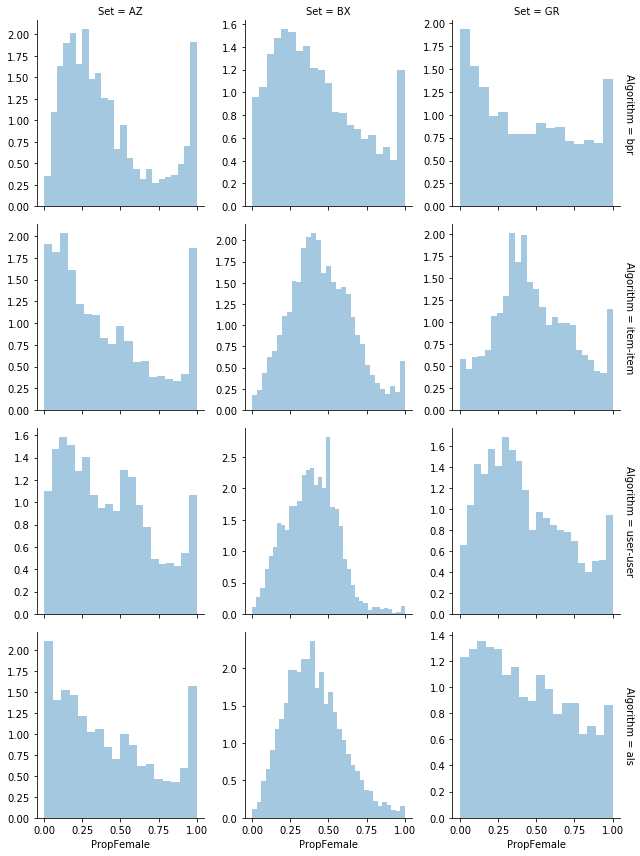

In [42]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropFemale', kde=False, norm_hist=True)

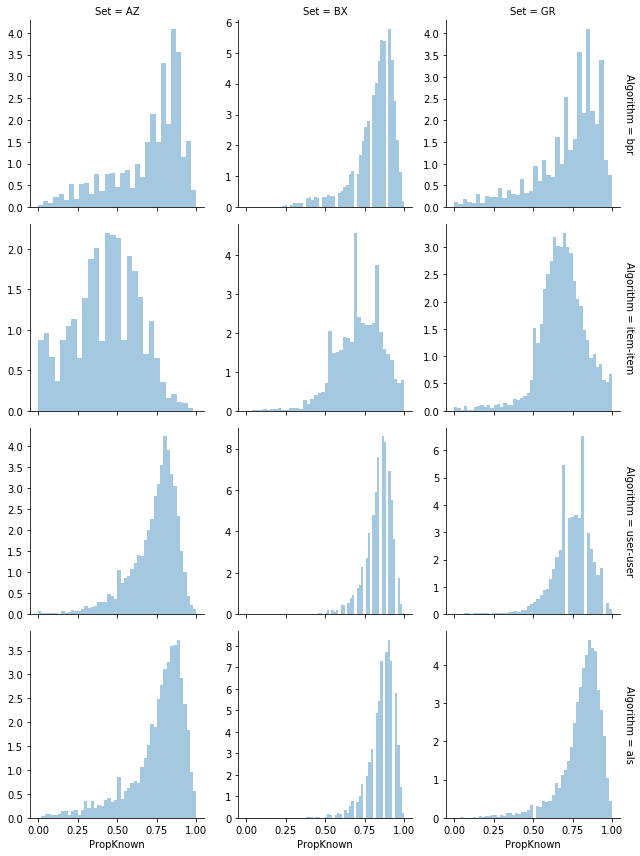

In [43]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropKnown', kde=False, norm_hist=True)

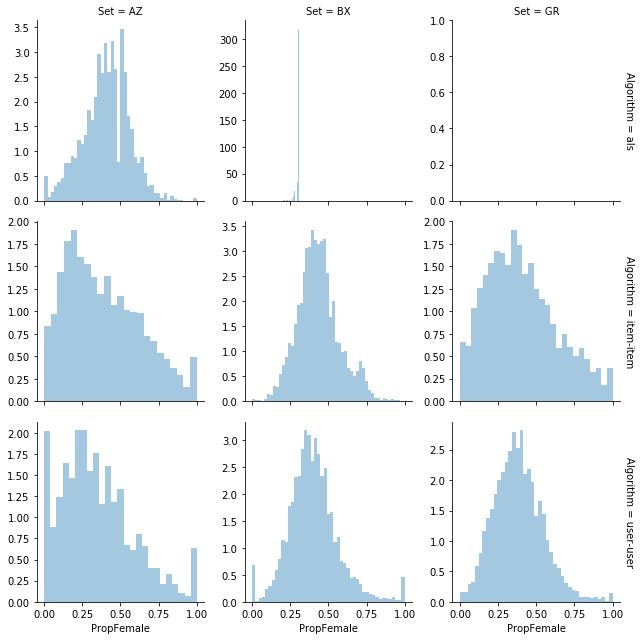

In [44]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropFemale', kde=False, norm_hist=True)

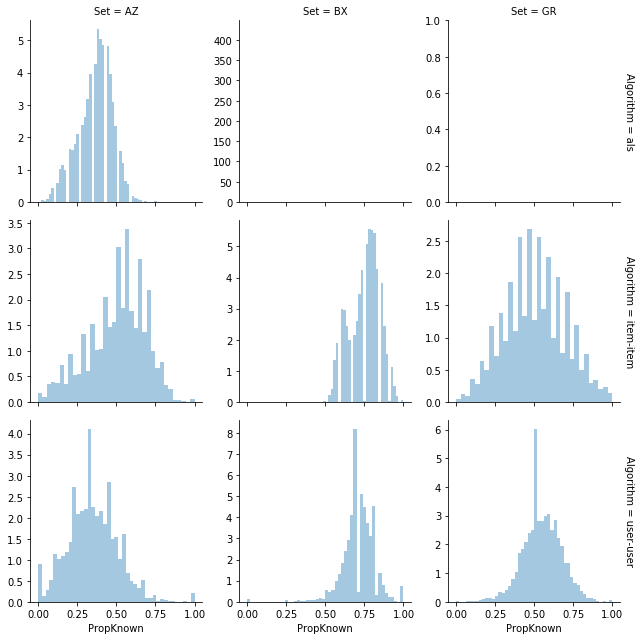

In [45]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropKnown', kde=False, norm_hist=True)

## Dummy Code Distributions

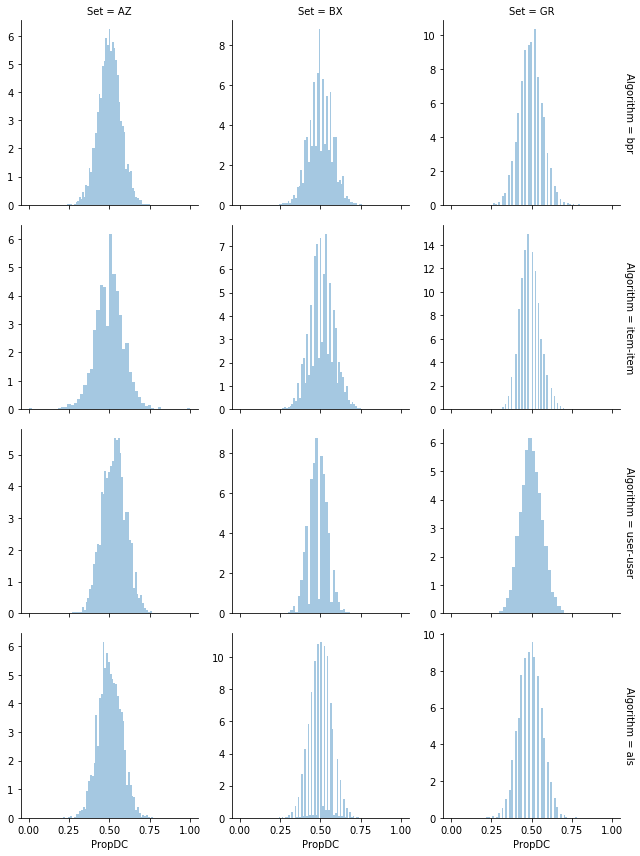

In [46]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropDC', kde=False, norm_hist=True)

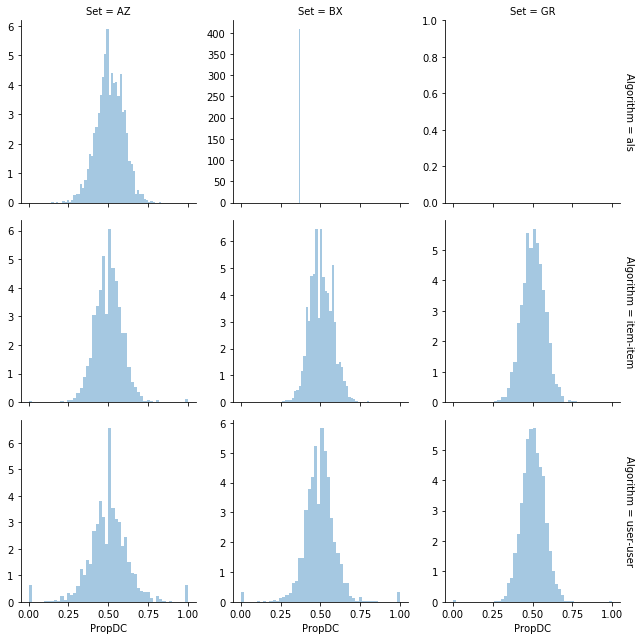

In [47]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropDC', kde=False, norm_hist=True)

## Prepare for Modeling

With this analysis, we need to prepare our recommendation data for modeling.

Because ALS on BX-E behaves _so_ badly, we can't really use it. Drop from further analysis.

In [48]:
rec_stats = rec_stats.drop(('BX-E', 'als'))

In [49]:
rec_stats.to_pickle('data/rec-data.pkl')

We also want to save this data for STAN.

In [50]:
def inf_dir(sname):
    return data_dir / sname / 'inference'

In [51]:
for sname, frame in rec_stats.groupby('Set'):
    print('preparing STAN input for', sname)
    lists = frame.reset_index().astype({'Algorithm': 'category'})
    algos = lists['Algorithm'].cat.categories
    print(sname, 'has algorithms', algos)
    
    # set up the users
    users = profiles.loc[sname, :]
    users = users.assign(unum=np.arange(len(users), dtype='i4') + 1)
    lists = lists.join(users[['unum']], on='user')
    
    data = {
        'A': len(algos),
        'J': len(users),
        'NL': len(lists),
        'n': users['Known'],
        'y': users['female'],
        'ru': lists['unum'],
        'ra': lists['Algorithm'].cat.codes + 1,
        'rn': lists['Known'],
        'ry': lists['female']
    }
    
    # and write
    dir = inf_dir(sname)
    dir.mkdir(exist_ok=True)
    in_fn = dir / 'full-inputs.json'
    in_fn.write_text(ujson.dumps(data))
    # in_fn.write_text(ujson.dumps(stan_inputs(frame, 'Known', 'female')))

preparing STAN input for AZ
AZ has algorithms Index(['als', 'bpr-imp', 'item-item', 'item-item-imp', 'user-user',
       'user-user-imp', 'wrls-imp'],
      dtype='object')
preparing STAN input for BX-E
BX-E has algorithms Index(['item-item', 'user-user'], dtype='object')
preparing STAN input for BX-I
BX-I has algorithms Index(['bpr', 'item-item', 'user-user', 'wrls'], dtype='object')
preparing STAN input for GR-E
GR-E has algorithms Index(['item-item', 'user-user'], dtype='object')
preparing STAN input for GR-I
GR-I has algorithms Index(['bpr', 'item-item', 'user-user', 'wrls'], dtype='object')
